### Домашнее задание по лекции 5

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. сделайте ее перрасчет (ресемплинг) в представление по неделям
3. Добавьте первые разности по стоимости доллара и евро к рублю. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm



from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression 
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import f_regression, mutual_info_regression

import seaborn as sns

from sklearn.decomposition import PCA
import scipy.stats as scs



from heapq import merge
import pickle

import warnings
warnings.filterwarnings("ignore")

In [82]:
def fill(df):
    if len(np.where(df.isna())[0]) > 0:
        print(np.where(df.isna()))
        df = df.fillna(method = 'ffill')
    return df

### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [83]:
BRENT = 'my_BRENT2019.csv'
data_brent = pd.read_csv(BRENT, index_col=[0], parse_dates=[0])
data_brent = data_brent.sort_index()
data_brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


### 2. Cделайте ее перрасчет (ресемплинг) в представление по неделям

In [84]:
# 2. сделайте ее перрасчет (ресемплинг) в представление по неделям
data_brent_w = data_brent.copy().resample('W').mean()
# удалим признаки dayofweek, hour, is_holiday,is_prev_holiday, is_next_holiday как неактуальные для недельного ресемплинга
non_actual_features = ['dayofmonth', 'dayofyear', 'dayofweek','is_holiday', 'is_prev_holiday', 'is_next_holiday']
data_brent_w.drop(non_actual_features, axis=1,inplace=True)
data_brent_w.head()

,Значение,year,month,quarter,weekofyear
Дата,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0


Text(0.5, 0, 'barrel')

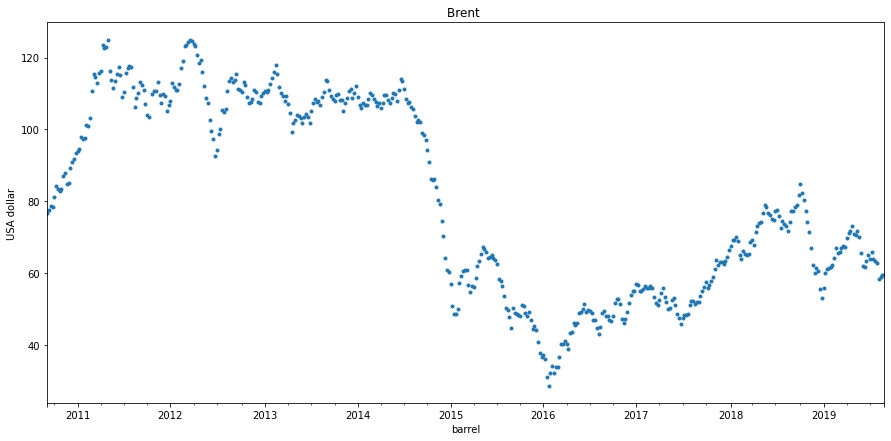

In [85]:
_ = data_brent_w['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('barrel')

### 3. Добавьте первые разности по стоимости доллара и евро к рублю.

In [86]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[0], parse_dates=[0])
rub_doll.index = pd.to_datetime(rub_doll['data'].values)
# rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll_w = rub_doll.copy().resample('W').mean()
rub_doll_w.tail()

,curs
2019-08-04,63.75872
2019-08-11,65.14700
2019-08-18,65.62408
2019-08-25,66.17588
2019-09-01,66.37676


In [87]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values)
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e_w = rub_e.copy().resample('W').mean()
rub_e_w.tail()

,curs
2019-08-04,70.83112
2019-08-11,72.88008
2019-08-18,73.22388
2019-08-25,73.37588
2019-09-01,73.60068


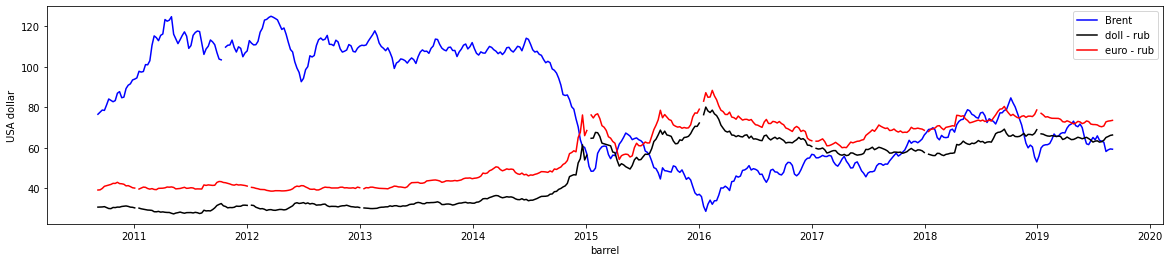

In [88]:
plt.figure(figsize=(20,4))
plt.plot(data_brent_w.index,data_brent_w['Значение'].values,'b', label='Brent ')
plt.plot(rub_doll_w.index,rub_doll_w['curs'].values,'k', label='doll - rub')
plt.plot(rub_e_w.index,rub_e_w['curs'].values,'r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('barrel')
plt.legend()
plt.show()

In [89]:
# посмотрим пропуски и заполним их
data_brent_w = fill(data_brent_w)
rub_doll_w = fill(rub_doll_w)
rub_e_w = fill(rub_e_w)

(array([58, 58, 58, 58, 58]), array([0, 1, 2, 3, 4]))
(array([ 18,  70, 122, 227, 279, 331, 383, 435]), array([0, 0, 0, 0, 0, 0, 0, 0]))
(array([ 18,  70, 122, 227, 279, 331, 383, 435]), array([0, 0, 0, 0, 0, 0, 0, 0]))


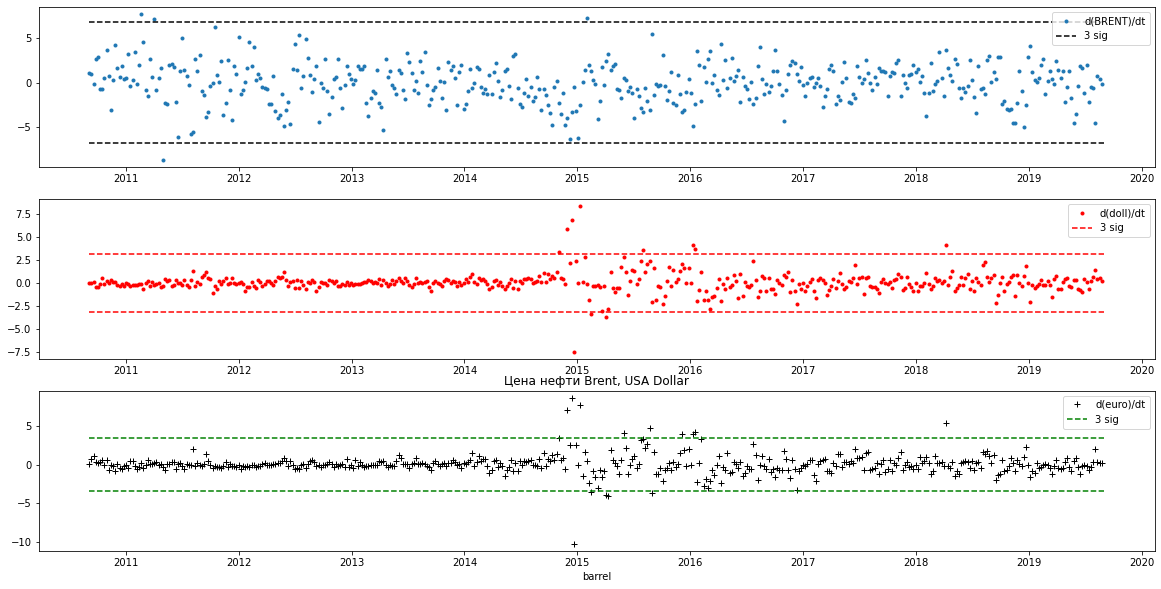

In [90]:
# первые разности
d_brent_data = data_brent_w['Значение'].values[1:]- data_brent_w['Значение'].values[:-1]
s_brent = np.std(d_brent_data) *3

d_rub_doll = rub_doll_w['curs'].values[1:]- rub_doll_w['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 * 3

d_rub_e = rub_e_w['curs'].values[1:]- rub_e_w['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(data_brent_w.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(data_brent_w.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(data_brent_w.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll_w.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll_w.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll_w.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e_w.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e_w.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e_w.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('barrel')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

# созраним индексы аномалий
ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

In [91]:
# найдем пересекающиеся аномалии

cross_anomal_carrency = np.intersect1d(ind_anomal_rubl_d, ind_anomal_rubl_e)
cross_anomal

array([221, 223, 224, 227, 232, 239, 279, 280, 396])

In [92]:
ind_anomal_brent

array([ 24,  30,  34, 230])

Видим индекс 230 цены на нефть рядом пересекающихся валютными аномалиями с индексом 232, возьмем по 2 точки соседние от нее

In [93]:
rub_doll.index[[228, 229, 230, 231, 232]]

DatetimeIndex(['2011-08-03', '2011-08-04', '2011-08-05', '2011-08-06',
               '2011-08-09'],
              dtype='datetime64[ns]', freq=None)

Добавим стоимость валюты в рублях и евро

In [99]:
data_brent_w['usd/rub']=rub_doll_w['curs'].shift(1)
data_brent_w['eur/rub']=rub_e_w['curs'].shift(1)
data_brent_w = data_brent_w.fillna(method = 'backfill')

In [109]:
def make_history(df, coll, dipp):
    for i in range(1, dipp):
        df[coll + '_p_' + str(i)] = df[coll].shift(i)
    df = df.fillna(method = 'backfill')
    return df

In [114]:
data_brent_w = make_history(data_brent_w, 'usd/rub', 4)
data_brent_w = make_history(data_brent_w, 'eur/rub', 4)

In [115]:
data_brent_w

,Значение,year,month,quarter,weekofyear,usd/rub,eur/rub,usd/rub_p_1,usd/rub_p_2,usd/rub_p_3,eur/rub_p_1,eur/rub_p_2,eur/rub_p_3
Дата,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,30.76125,39.204675,30.76125,30.76125,30.76125,39.204675,39.204675,39.204675
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,30.76125,39.204675,30.76125,30.76125,30.76125,39.204675,39.204675,39.204675
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,30.79402,39.293360,30.76125,30.76125,30.76125,39.204675,39.204675,39.204675
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,30.84672,39.977740,30.79402,30.76125,30.76125,39.293360,39.204675,39.204675
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,30.99920,41.042640,30.84672,30.79402,30.76125,39.977740,39.293360,39.204675
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-04,62.791667,2019.0,7.500000,3.000000,31.0,63.10142,70.443740,62.85624,63.48990,63.35222,70.698120,71.350220,71.521780
2019-08-11,58.236667,2019.0,8.000000,3.000000,32.0,63.75872,70.831120,63.10142,62.85624,63.48990,70.443740,70.698120,71.350220
2019-08-18,59.033333,2019.0,8.000000,3.000000,33.0,65.14700,72.880080,63.75872,63.10142,62.85624,70.831120,70.443740,70.698120


In [137]:
def data_prepare(data, target, h, p, n_best_features):
     #Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)
    scl_target=StandardScaler() 
    scl_x=StandardScaler() 
    # тут мы сдвигаем y влево на h
    target = data[target].values[p+h:].reshape((data.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    # выравниваем X справа для равенства размеров X и y
    X = data.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    
    print(f'Проверяем равенство размеров - Х: {X.shape}, размер y: {y.shape}')
      
    #Применим автоматизацию выбора через SelectKBest c выделением 7 лучших признаков.
    sfk = SelectKBest(f_regression, k=n_best_features)
    X_new1 = sfk.fit_transform(X, y.ravel())
#     print(f'Размер таблицы после выделения лучших признаков по SelectKBest {X_new1.shape}')
    column_names = list(data.columns[sfk.get_support()])
    print(f'Лучшие признаки по SelectKBest: {column_names}')
    
    # Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.
    
    sfp=SelectPercentile(f_regression, percentile=20)
    X_new2 = sfp.fit_transform(X, y.ravel())
    #print(f'Размер таблицы после выделения лучших признаков по процентному отбору {X_new2.shape}')
    column_names = list(data.columns[sfp.get_support()])
    print(f'Лучшие признаки по процентному отбору: {column_names}')
    
    # Проверим результат оценки признаков по GradientBoostingRegressor и построим новое пространство в X_new3
    
    gr_model = GradientBoostingRegressor(max_depth=5, n_estimators=10).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = n_best_features)
    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    #print(f'Размер таблицы после выделения лучших признаков по GradientBoostingRegressor {X_new3.shape}')
    column_names = list(data.columns[sfm.get_support()])
    print(f'Лучшие признаки по GradientBoostingRegressor: {column_names}')
    
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]
    
    # Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов.
    list_par=list(set(merge(list_param_k, list_param_p, list_param_m)))
    X_new = X[:,list_par]
    print(f'Список лучших параметров: {list_par}')
    
    return X_new, X, y, scl_x, scl_target, list_par

In [127]:
# функция разделения данных на трейн и тест
def split_data( data, coll_date ,split_date ):
    return data.loc[data.index.get_level_values(coll_date) <= split_date].copy(), \
           data.loc[data.index.get_level_values(coll_date) >  split_date].copy()

In [130]:
# функция расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [128]:
# функция построения и оценки модели
def model(data, target, title, coll_date, split_date, X_new, X, y, scl_x, scl_target, n_iter_search, h, p):
    # Разделение данных на тестовые и тренировочные
    train, test = split_data( data, coll_date, split_date)
    # строим график
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel('Время')
    plt.ylabel(title)
    plt.plot(train.index.get_level_values(coll_date),train[target], label='train data' )
    plt.plot(test.index.get_level_values(coll_date),test[target], label='test data')
    plt.title( 'Тестовые и тренировочные данные' )
    plt.legend()
    plt.show()
    
    # формируем признаки и таргет на трейне и на тесте
    X_train =X_new[:train.shape[0],:]
    y_train =y[:train.shape[0],0]
    X_test =X_new[train.shape[0]:,:]
    y_test =y[train.shape[0]:,0]
    
    # выясняем лучшие параметры
    param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

    n_iter_search = 10

    model_gr =GradientBoostingRegressor()

    random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

    random_search.fit(X_train, y_train)

    print(f'Лучшие параметры: {random_search.best_params_}')
    print(f'Лучшая точность при данных параметрах: {random_search.best_score_}')
    
    # строим лучшую модель
    model_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_.get('max_depth'),  
                                             n_estimators=random_search.best_params_.get('n_estimators'))
    model_g_best.fit( X_train, y_train ) 
    y_test_pred_g = model_g_best.predict(X_test)
    
    #смотрим метрики
    er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

    print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
    
    # рисуем график предикта и реальный
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel('Время')
    plt.ylabel(title)
    plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
    plt.plot(test.index[h+p:],y_test, label='test data')
    plt.legend()
    plt.show()
    
    # исследуем график корреляций
    lag=10
    p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
    for i in range(lag):
        c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
        p_cor.append(c)    

    plt.plot(np.array(p_cor) )  
    plt.xlabel('лаг корреляции')
    plt.ylabel('cor_coeff')
    plt.title('корреляция с целью для предсказаний с лагом просмотра')
    plt.show()
    
    #сохранение модели
    filename = 'final_model.sav'
    pickle.dump(model_g_best, open(filename, 'wb'))

    filename = 'final_scaler_y.sav'
    pickle.dump(scl_target, open(filename, 'wb'))

    filename = 'final_scaler_x.sav'
    pickle.dump(scl_x, open(filename, 'wb'))
    
    return X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g


### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

Проверяем равенство размеров - Х: (455, 13), размер y: (455, 1)
Лучшие признаки по SelectKBest: ['Значение', 'usd/rub', 'usd/rub_p_1', 'usd/rub_p_2', 'usd/rub_p_3']
Лучшие признаки по процентному отбору: ['Значение', 'usd/rub', 'usd/rub_p_1']
Лучшие признаки по GradientBoostingRegressor: ['Значение', 'usd/rub', 'eur/rub', 'usd/rub_p_1', 'usd/rub_p_3']
Список лучших параметров: [0, 5, 6, 7, 8, 9]


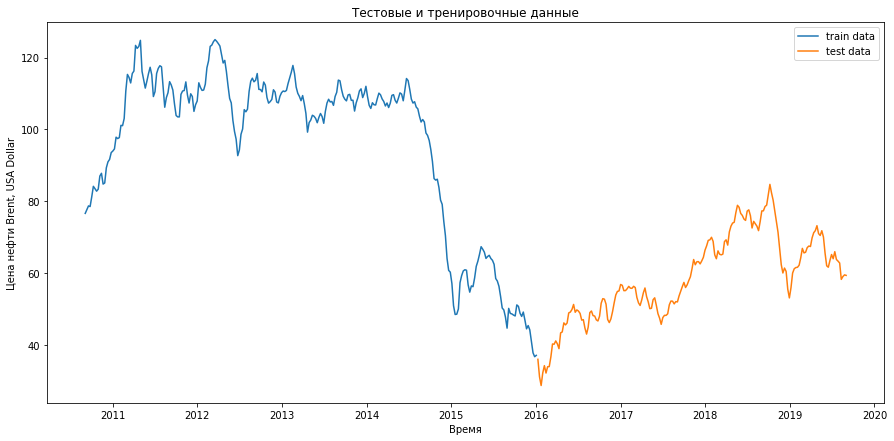

Лучшие параметры: {'n_estimators': 200, 'max_depth': 2}
Лучшая точность при данных параметрах: 0.6358811351120259
ошибка mse :   0.061394106185016464 
ошибка mae  :   0.174288619390652 
оценка R2 :   0.5699267583803481
ошибка градиентного бустинга MAPE :   6.985896262037469 %


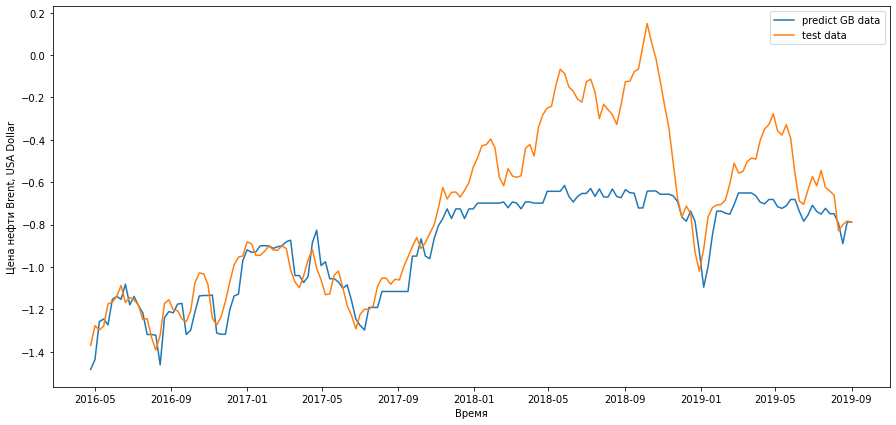

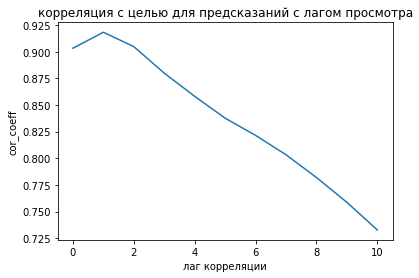

In [138]:
# подготовка признаков и окончательного датасета для предсказания 1-й точки от текущей (h = 1)
X_new, X, y, scl_x, scl_target, list_par = data_prepare(data_brent_w, 'Значение', h = 1, p = 14, n_best_features = 5)
data_h1 = [X_new, X, y, scl_x, scl_target,list_par]
#строим модель предсказания 1-й точки от текущей (h = 1)
X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g = model(data_brent_w, target = 'Значение', title='Цена нефти Brent, USA Dollar', 
      coll_date = 'Дата', split_date='01-06-2016', X_new=X_new, X=X, y=y, scl_x=scl_x, scl_target=scl_target, n_iter_search=10, h=1, p=14)
model_h1 = [X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g]

### Для возможности сравнения качества моделей построим такую же модель только без регрессоров в виде валют

In [139]:
brent_no_regress = data_brent.copy().resample('W').mean()
# удалим признаки dayofweek, hour, is_holiday,is_prev_holiday, is_next_holiday как неактуальные для недельного ресемплинга
non_actual_features = ['dayofmonth', 'dayofyear', 'dayofweek','is_holiday', 'is_prev_holiday', 'is_next_holiday']
brent_no_regress.drop(non_actual_features, axis=1,inplace=True)
brent_no_regress = fill(brent_no_regress)
brent_no_regress.head()

(array([58, 58, 58, 58, 58]), array([0, 1, 2, 3, 4]))


,Значение,year,month,quarter,weekofyear
Дата,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0


Проверяем равенство размеров - Х: (455, 5), размер y: (455, 1)
Лучшие признаки по SelectKBest: ['Значение', 'year', 'month', 'quarter', 'weekofyear']
Лучшие признаки по процентному отбору: ['Значение']
Лучшие признаки по GradientBoostingRegressor: ['Значение']
Список лучших параметров: [0, 1, 2, 3, 4]


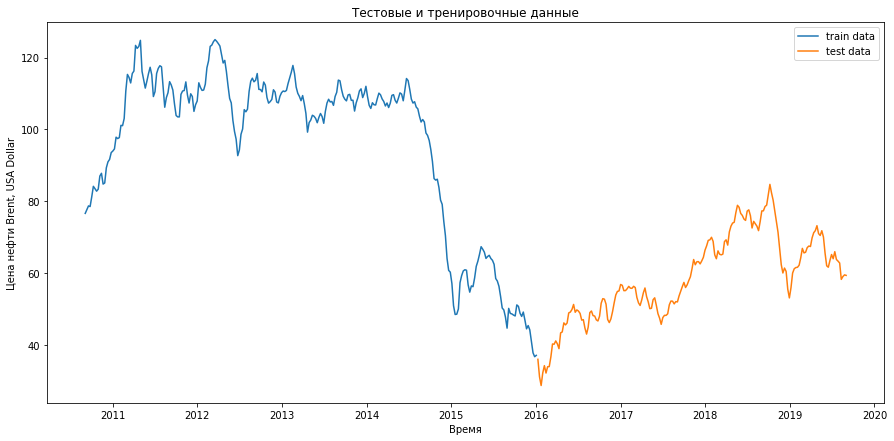

Лучшие параметры: {'n_estimators': 300, 'max_depth': 2}
Лучшая точность при данных параметрах: 0.6339879377646962
ошибка mse :   0.013767134957735783 
ошибка mae  :   0.09335928780233513 
оценка R2 :   0.9035595315738357
ошибка градиентного бустинга MAPE :   4.037659518942525 %


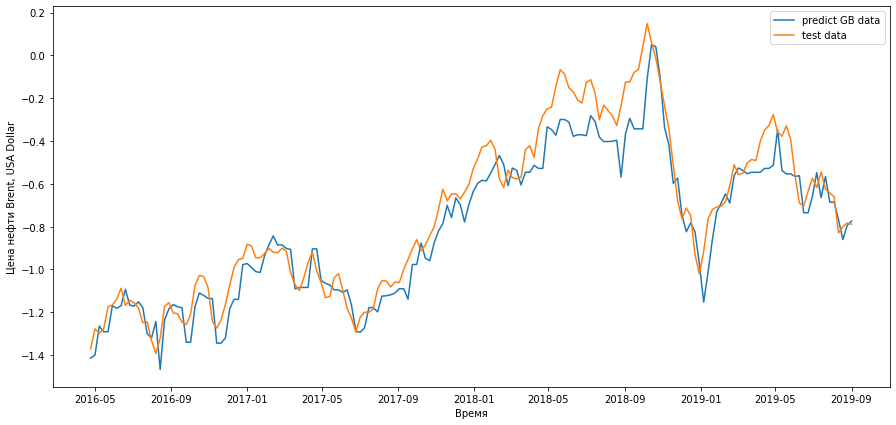

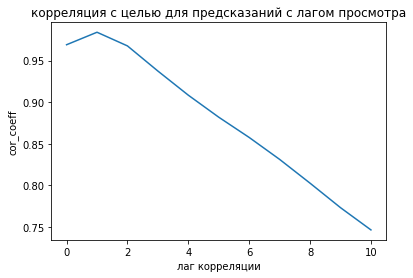

In [140]:
# подготовка признаков и окончательного датасета для предсказания 1-й точки от текущей (h = 1)
X_new, X, y, scl_x, scl_target, list_par = data_prepare(brent_no_regress, 'Значение', h = 1, p = 14, n_best_features = 5)
data_h1 = [X_new, X, y, scl_x, scl_target,list_par]
#строим модель предсказания 1-й точки от текущей (h = 1)
X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g = model(brent_no_regress, target = 'Значение', title='Цена нефти Brent, USA Dollar', 
      coll_date = 'Дата', split_date='01-06-2016', X_new=X_new, X=X, y=y, scl_x=scl_x, scl_target=scl_target, n_iter_search=10, h=1, p=14)
model_h1 = [X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g]

### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

ошибка прямой модели (MAPE) = 4%
ошибка модели с валютными регрессорвами (MAPE)= 7%

Вывод: расчеты показывают, что прогнозирование рыночных трендов с регрессорами менее точно чем без регресоров в виде дополнительных рыночных инструментов, но возможно это связано с настройкой самих признаков, возможно неверно подобран лаг опережения стоимости нефти и курсов валют.

Однако, подобную тенденцию я уже видел при использовании FBProphet